# Image Captioning using Tensorflow 2.0

### I'm using the Flickr8k dataset. For the transfer learning I'm using Inception Resnet 2 for the images and BLEU for the word embeddings. 

In [21]:
import os
import json
import pickle
import string
import pandas as pd
import shutil
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

In [42]:
root_path = os.getcwd() 
data_dir = os.path.join(root_path, 'data')
dataset_dir = os.path.join(data_dir, 'Flickr8k_Dataset')
descriptions_file = os.path.join(data_dir, 'dataset.json') 

### Extracting the image features using Inception Resnet v2

In [23]:
inception = InceptionResNetV2()
feat_extractor = Model(inputs=inception.inputs, outputs=inception.layers[-2].output)

In [24]:
def extract_features(path):
    start = time.time()
    features = {}
    for filename in filenames:
        filepath = os.path.join(dataset_dir, filename + '.jpg')
        img = load_img(filepath, target_size=(299, 299))
        img = img_to_array(img)
        img = np.expand_dims(img, 0)
        img = preprocess_input(img)
        feature = feat_extractor.predict(img)
        img_id = filename.split('.')[0]
        features[img_id] = feature
    print(f'Extracted Features: {len(features)}')
    pickle.dump(features, open('InceptRes2Features.pkl', 'wb'))
    end = time.time()
    print(f'time taken: {(end - start)/60:.2f} min')

In [25]:
feats_file_path = os.path.join(root_path, 'InceptRes2Features.pkl')
if os.path.exists(feats_file_path):
    feats_data = pickle.load(open(feats_file_path, 'rb'))
else:
    extract_features(dataset_dir)
    feats_data = pickle.load(open(feats_file_path, 'rb'))

In [26]:
# Checking the shape of the picture features
print(feats_data['2513260012_03d33305cf'].shape)
len(feats_data)

(1, 1536)


8000

### Preprocessing the image descriptions

In [27]:
with open(descriptions_file, 'r') as f:
    data = json.load(f)

null_punct = str.maketrans('', '', string.punctuation)
descriptions = {}
filenames = []
MAX_LEN = 0
for item in data['images']:
    name = item['filename'].split('.')[0]
    descriptions[name] = []
    for sentence in item['sentences']:
        desc = sentence['tokens']
        desc = [word.lower() for word in desc]
        desc = [w.translate(null_punct) for w in desc]
        desc = [word for word in desc if len(word)>1]
        desc = [word for word in desc if word.isalpha()]
        desc = '<start> ' + " ".join(desc) + ' <end>'
        desc = "".join(desc)
        MAX_LEN = max(MAX_LEN,len(desc.split()))
        descriptions[name].append(desc)
        filenames.append(name)
tokens = set()
for key in descriptions:
    [tokens.update(d.split()) for d in descriptions[key]]
tokens = sorted(tokens)

print(MAX_LEN) # longest sentence
print(len(tokens)) # number unique words

35
8320


In [28]:
TOP_K = 8320
# I removed the <> symbolds from the default filter because I'm using <start> and <end> keywords
tokenizer = Tokenizer(TOP_K, oov_token='<unk>', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') 
tokenizer.fit_on_texts(tokens)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [29]:
VOCAB_SIZE = len(tokens) + 2 # because indexes 0 and 1 are reserved for <pad> and <unk>
VOCAB_SIZE

8322

In [30]:
# split the data to train and test sets
all_ids = [i for i in descriptions]
train_images = {i: feats_data[i] for i in all_ids[:7936]}
train_descriptions = {i: descriptions[i] for i in all_ids[:7936]}
test_descriptions = {i: descriptions[i] for i in all_ids[7936:]}
test_images = [id + '.jpg' for id in all_ids if id in test_descriptions]
print(len(train_descriptions))
print(len(train_images))
print(len(test_descriptions))

7936
7936
64


### Creating a fast data generator using the keras Sequence class

In [31]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images_dict, features, batch_size, shuffle=True):
        self.images_dict = images_dict
        self.features_dict = features
        self.features_names = list(self.features_dict)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.features_names) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size: (index+1) * self.batch_size]
        features_batch = [self.features_names[k] for k in indexes]
        X1, X2, y = self.__data_generation(features_batch)
        return [X1, X2], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.features_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, features_batch):
        'Generates data containing batch_size samples'
        X1, X2, y = [], [], []
        for i, key in enumerate(features_batch):
            img_feats = self.images_dict[key][0]
            for description in self.features_dict[key]:
                indexed_caption = tokenizer.texts_to_sequences(description.split())
                for i in range(1, len(indexed_caption)):
                    inp_array, out_array = indexed_caption[:i], indexed_caption[i]
                    inp_array = pad_sequences([inp_array], maxlen=MAX_LEN, padding='post')[0]
                    inp_array = inp_array.reshape((MAX_LEN,))
                    out_array = to_categorical([out_array], num_classes=VOCAB_SIZE)[0]
                    X1.append(img_feats)
                    X2.append(inp_array)
                    y.append(out_array)
        return np.array(X1), np.array(X2), np.array(y)

g = DataGenerator(train_images, train_descriptions, 1)
[a,b], c = next(iter(g))
print(a.shape)
print(b.shape)
print(c.shape)

(52, 1536)
(52, 35)
(52, 8322)


### Transfer learning for the embedding layer

In [32]:
BUFFER_SIZE = 1000
EMBEDDING_DIM = 200
FEATURES_SHAPE = 1536

In [33]:
# I'm using the pretrained Glove model embedding weights and setting them to the model embedding layer
embeddings_index = {} 
with open(os.path.join(data_dir, 'glove.6B.200d.txt'), encoding="utf-8") as f:

    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:31, 12754.23it/s]


Found 400000 word vectors.


In [34]:
# Get 200-dim dense vector for each word in the vocabulary
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[idx] = embedding_vector

embedding_matrix.shape

(8322, 200)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1536)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 200)      1664400     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 1536)         0           input_5[0][0]                    
____________________________________________________________________________________________

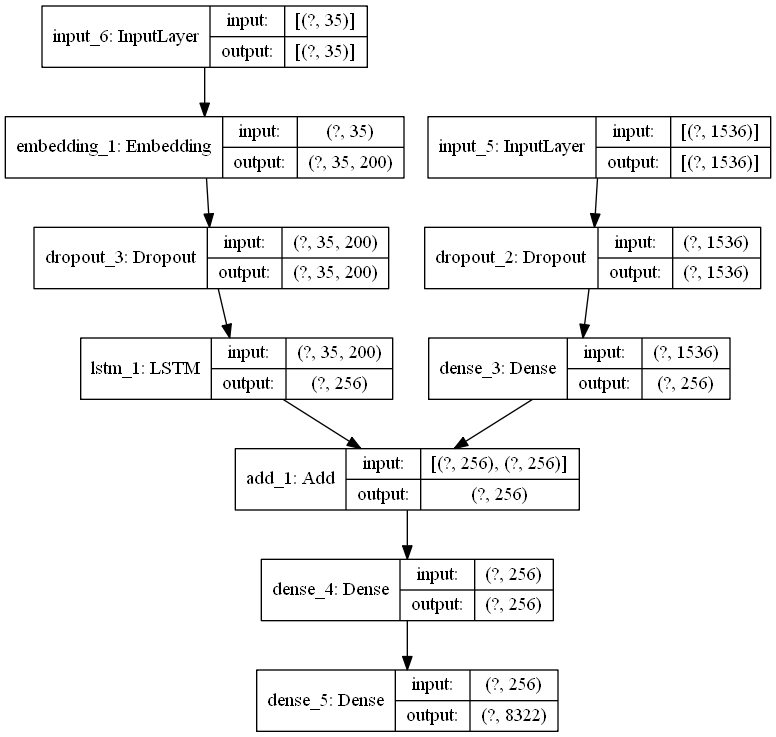

In [35]:
inputs1 = Input(shape=(FEATURES_SHAPE,))
emb = Dropout(0.3)(inputs1)
emb = Dense(256, activation='relu')(emb)

inputs2 = Input(shape=(MAX_LEN,))
seq = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True)(inputs2)
seq = Dropout(0.3)(seq)
seq = LSTM(256, dropout=0.2, recurrent_dropout=0.3)(seq)

decoder = add([emb, seq])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# setting the embedding weights to the pretrained "Glove" model
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001))
model.summary()
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [0]:
BATCH_SIZE = 64
EPOCHS = 40
generator = DataGenerator(train_images, train_descriptions, BATCH_SIZE)
history = model.fit(generator, epochs=EPOCHS, verbose=1)
model.save_weights(os.path.join(root_path + 'model.h5'))

  ...
    to  
  ['...']
Train for 124 steps
Epoch 1/40
124/124 [==============================] - 45s 365ms/step - loss: 5.6136
Epoch 2/40
124/124 [==============================] - 43s 346ms/step - loss: 4.4625
Epoch 3/40
124/124 [==============================] - 43s 343ms/step - loss: 4.0528
Epoch 4/40
124/124 [==============================] - 42s 340ms/step - loss: 3.8206
Epoch 5/40
124/124 [==============================] - 42s 340ms/step - loss: 3.6530
Epoch 6/40
124/124 [==============================] - 42s 339ms/step - loss: 3.5229
Epoch 7/40
124/124 [==============================] - 42s 338ms/step - loss: 3.4164
Epoch 8/40
124/124 [==============================] - 42s 338ms/step - loss: 3.3251
Epoch 9/40
124/124 [==============================] - 42s 339ms/step - loss: 3.2402
Epoch 10/40
124/124 [==============================] - 42s 338ms/step - loss: 3.1653
Epoch 11/40
124/124 [==============================] - 42s 338ms/step - loss: 3.1013
Epoch 12/40
124/124 [========

### A second way of training the model using regular generator

In [36]:
BATCH_SIZE = 64

def data_generator(descr_dict, batch_size=BATCH_SIZE):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key, descr_list in descr_dict.items():
            n += 1
            img_feats = feats_data[key][0]
            for description in descr_list:
                indexed_caption = tokenizer.texts_to_sequences(description.split())
                for i in range(1, len(indexed_caption)):
                    inp_array, out_array = indexed_caption[:i], indexed_caption[i]
                    inp_array = pad_sequences([inp_array], maxlen=MAX_LEN, padding='post')[0]
                    inp_array = inp_array.reshape((MAX_LEN,))
                    out_array = to_categorical([out_array], num_classes=VOCAB_SIZE)[0]
                    X1.append(img_feats)
                    X2.append(inp_array)
                    y.append(out_array)
            if n == batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

[a, b], c = next(data_generator(train_descriptions, batch_size=3))
print(a.shape)
print(b.shape)
print(c.shape)

(152, 1536)
(152, 35)
(152, 8322)


In [ ]:
# model.load_weights('gdrive/My Drive/Datasets/model.h5')
BATCH_SIZE = 32
EPOCHS = 1
loss = 0
STEPS_PER_EPOCH = len(descriptions) // BATCH_SIZE
optimizer = tf.keras.optimizers.Adam(lr=0.001)
for epoch in range(EPOCHS):
    generator = data_generator(train_descriptions, BATCH_SIZE)
    for batch in tqdm(range(STEPS_PER_EPOCH), desc=f'Epoch: {epoch+1}'):
        (img_arr, sent_arr), outp_arr = next(generator)
        with tf.GradientTape() as tape:
            prediction = model((img_arr, sent_arr))
            outp_arr = tf.constant(outp_arr)
            loss = tf.keras.losses.categorical_crossentropy(outp_arr, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print('loss', np.mean(loss))

In [0]:
# model.save_weights('gdrive/My Drive/Datasets/model.h5')

In [38]:
def get_features(filepath, model):
    img = load_img(filepath, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, 0)
    img = preprocess_input(img)
    feature = model.predict(img)
    return feature

def generate_caption(picture, model, feat_extractor):
    pic = get_features(picture, feat_extractor)
    caption = '<start>'
    for i in range(MAX_LEN):
        seq = [tokenizer.word_index[s] if caption != '<start>' else tokenizer.word_index[caption] for s in caption.split()]
        padded = pad_sequences([seq], MAX_LEN, padding='post')
        predictions = model([pic, padded])
        highest_pred = np.argmax(predictions)
        word = tokenizer.index_word[highest_pred]
        caption += ' ' + word
        if word == '<end>':
            break
    caption = caption.split()
    caption = caption[1:-1]
    caption = " ".join(caption)
    return caption

### Checking various pictures that the model hasn't seen. The result is quite good

small tan dog runs through the grass


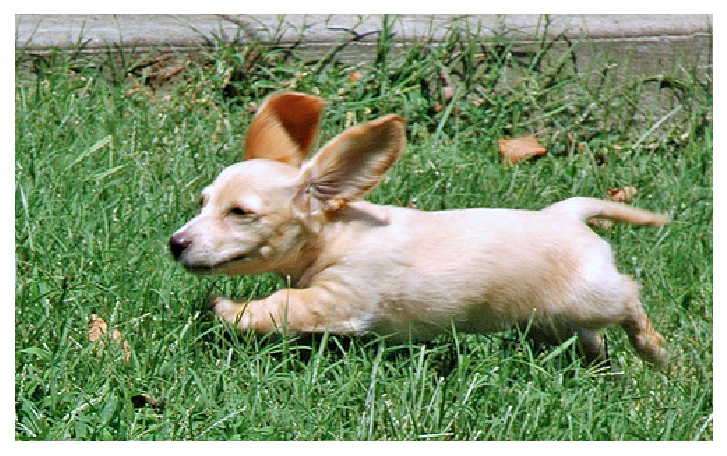

small child in blue shirt is putting at the camera


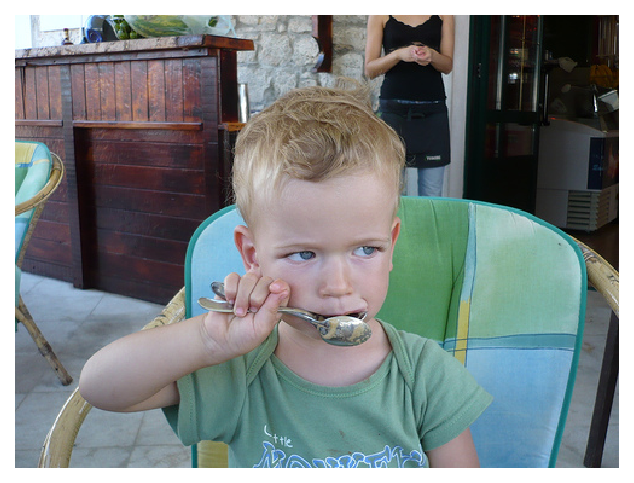

two women walking on the sidewalk


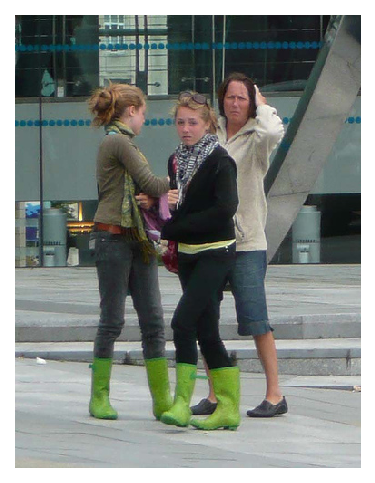

two boys are walking in field of grass


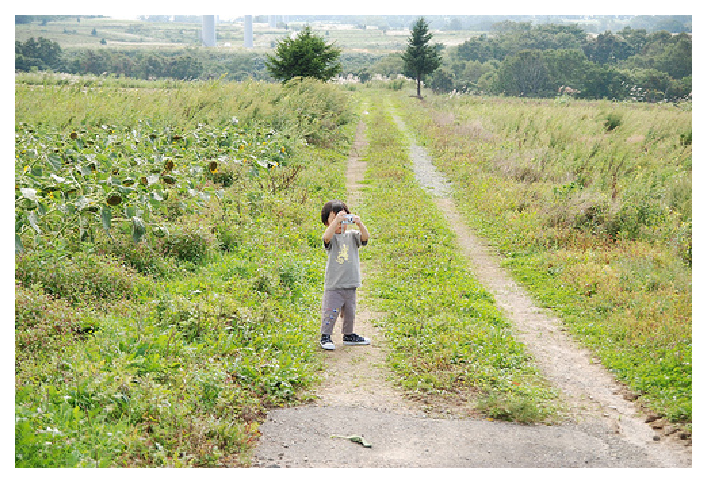

boy in blue shirt and tie tie jumping skateboard down railing


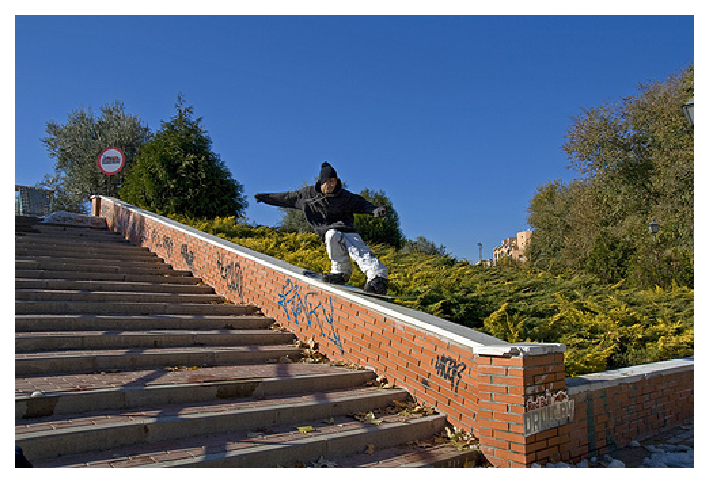

man in suit and tie smokes cigarette


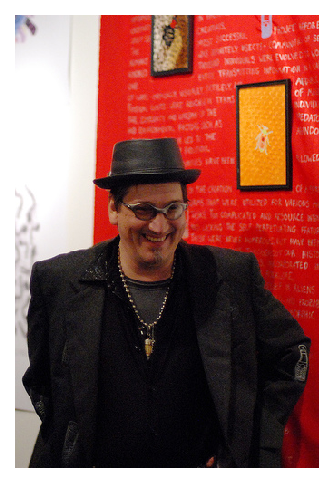

man and woman walking down the sidewalk


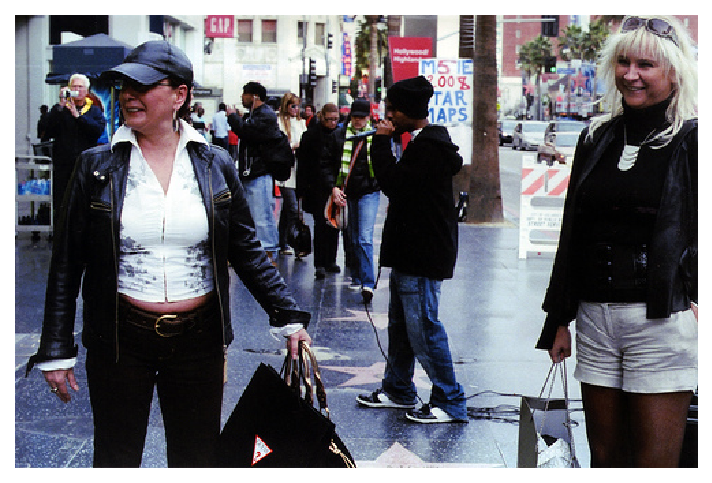

man in red shirt is standing in front of waterfall


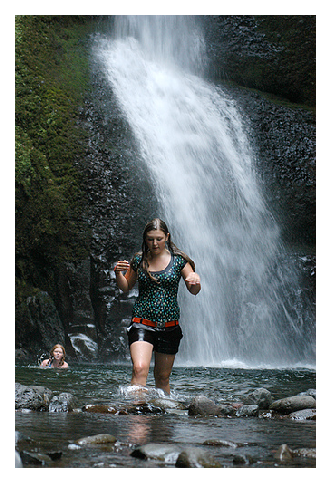

two dogs are playing in the grass


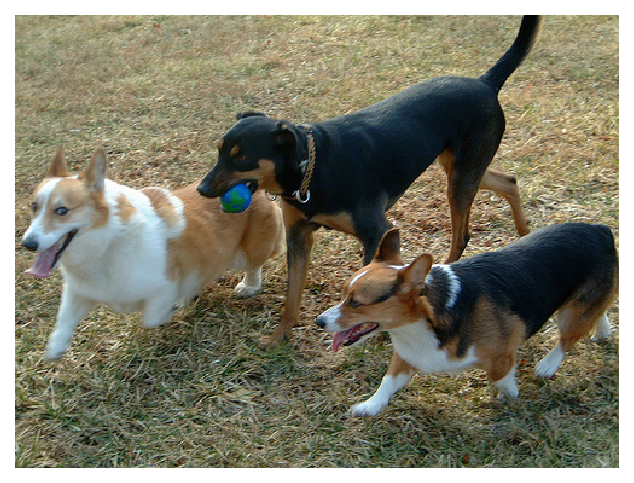

two boys are playing in the ocean


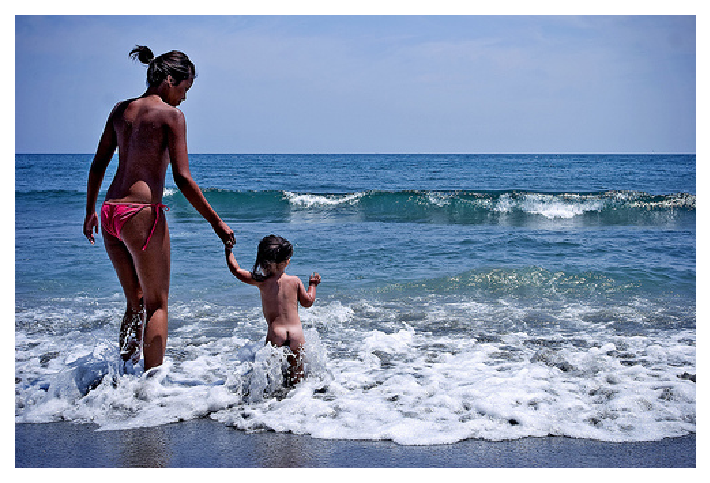

In [46]:
model.load_weights(os.path.join(root_path, 'model.h5'))
test_images_dir = os.path.join(data_dir, 'test_images')
for image in os.listdir(test_images_dir)[:10]:
    plt.figure(figsize=(6, 4), dpi=150)
    caption = generate_caption(os.path.join(test_images_dir, image), model, feat_extractor)
    print(caption)
    pic = load_img(os.path.join(test_images_dir, image))
    plt.imshow(pic)
    plt.axis('off')
    plt.show()